### Figure 4: QQ plot

In [1]:
import numpy as np
# from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from utils.data import load_tc_data
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
# TODO: check x and y axes obs vs preds

In [2]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

In [3]:
def calc_ensemble_percentile(ensemble,analysis,percentiles):
	ensemble_p=np.zeros((1,len(percentiles)))
	print(ensemble.shape)
	for i in range(1):
		if analysis == 'Mean' or analysis == 'Mean | extremes':
			p = np.percentile(np.mean(np.mean(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Peak' or analysis == 'Peak | extremes':
			p = np.percentile(np.max(np.max(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Total' or analysis == 'Total | extremes':
			p = np.percentile(np.sum(np.sum(ensemble[:,:,:,i],axis=1),axis=1), percentiles)
		elif analysis == 'Core' or analysis == 'Core | extremes':
			mask=radMask((25,25),25,ensemble[0,:,:,0])
			n,_,_,_ = ensemble.shape
			mask = np.expand_dims(mask,axis=0)
			mask = np.repeat(mask,n,axis=0)
			p = np.percentile(np.ma.array(ensemble[:,:,:,i], mask=mask), percentiles)
		ensemble_p[i] = p
	ensemble_mean = np.mean(ensemble_p,axis=0)
	ensemble_std = np.std(ensemble_p,axis=0)
	ensemble_min = np.min(ensemble_p,axis=0)
	ensemble_max = np.max(ensemble_p,axis=0)
	return ensemble_mean,ensemble_min,ensemble_max

In [4]:

def plot_qq(ax,analysis,pred,pred_2,pred_og,real,cnn=False):
	percentiles = np.arange(0,100,0.01)

	if analysis == 'Mean' or analysis == 'Mean | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.mean(np.mean(real,axis=1),axis=1), percentiles)

	elif analysis == 'Peak' or analysis == 'Peak | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.max(np.max(real,axis=1),axis=1), percentiles)

	elif analysis == 'Total' or analysis == 'Total | extremes':
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.sum(np.sum(real,axis=1),axis=1), percentiles)

	elif analysis == 'Core' or analysis == 'Core | extremes':
		mask=radMask((25,25),25,real[0,:,:,0])
		n,_,_,_ = real.shape
		mask = np.expand_dims(mask,axis=0)
		mask = np.repeat(mask,n,axis=0)
		dsrnngan_p,dsrnngan_min,dsrnngan_max = calc_ensemble_percentile(pred,analysis,percentiles)
		pred2_p,pred2_min,pred2_max = calc_ensemble_percentile(pred_2,analysis,percentiles)
		predog_p,predog_min,predog_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
		real_p = np.percentile(np.ma.array(real, mask=mask), percentiles)
	
	ax.scatter(real_p,dsrnngan_p,color='#729ea1')
	ax.scatter(real_p,pred2_p,color='Green')
	ax.scatter(real_p,predog_p,color='Pink')

	x_y = np.arange(0,1500,1)
	ax.plot(x_y,x_y,'--',color='black')
	if analysis == 'Mean':
		ax.legend(['WGAN_1D','WGAN_2D','WGAN_OG'],frameon=False,fontsize=16)
	ax.fill_between(real_p, dsrnngan_min, dsrnngan_max,color='#729ea1',alpha=0.2)
	ax.fill_between(real_p, pred2_min, pred2_max,color='Green',alpha=0.2)
	ax.fill_between(real_p, predog_min, predog_max,color='Pink',alpha=0.2)
	ax.set_xlabel('Observed rain (mm / h)',fontsize=18)
	ax.set_ylabel('Predicted rain (mm / h)',fontsize=18)
	ax.set_title(analysis,fontsize=18,fontweight='bold')
	ax.tick_params(axis='both', which='major', labelsize=14)
	if analysis == 'Mean | extremes':
		ax.set_ylim([0,20])
		ax.set_xlim([0,20])
		ax.set_yticks([0,5,10,15,20])
	elif analysis == 'Peak | extremes':
		ax.set_ylim([0,750])
		ax.set_xlim([0,750])
		ax.set_xticks([0,100,200,300,400,500,600,700])
	elif analysis == 'Core | extremes':
		ax.set_ylim([0,300])
		ax.set_xlim([0,300])
	elif analysis == 'Mean':
		ax.set_ylim([0,20])
		ax.set_xlim([0,20])
	elif analysis == 'Peak':
		ax.set_ylim([0,400])
		ax.set_xlim([0,400])
	elif analysis == 'Core':
		ax.set_ylim([0,150])
		ax.set_xlim([0,150])
		ax.set_xticks([0,10,20,30,40,50,60,70])

	print(analysis)
	return ax



In [5]:
# model = ''
# # set mode
# mode = 'validation'
# print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

# # load datasets
# real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')
# real_2,inputs_2,pred_2,meta_2,inputs_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
# meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
# # modular_pred_2 = np.load('/user/home/al18709/work/gan_predictions_20/modular_part2_lowres_predictions_pred-opt_modular_part2_raw.npy')
# modular_pred_2 = np.load('/user/home/al18709/work/gan_predictions_20/modular_part2_lowres_predictions_validation_pred-opt_scalar_test_run_1_pred-opt_modular_part2_raw.npy')
# meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')
# modular_1_scalar = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_1.npy')


# pred_mraw = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')
# # pred_weighted = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_pred-opt_modular_part2_raw.npy')
# print(pred.shape)
# print(inputs.shape)
# print(real.shape)


In [6]:
# modular_1_real = np.load('/user/home/al18709/work/gan_predictions_20/extreme_valid_pred-opt_scalar_test_run_1.npy')
# x = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/extreme_valid_X.npy')
# print(modular_1_scalar)
# print(modular_1_real)
# print(x.shape)

In [7]:
# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')

In [8]:

# load HighResMIP CMCC-CM2-VHR4 historical NH
CMCC_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_NH.npy')

# load HighResMIP CMCC-CM2-VHR4 historical SH
CMCC_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_SH.npy')

# load HighResMIP HadGEM3-GC31-HM   historical NH
hadgem_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_NH.npy')

# # load HighResMIP HadGEM3-GC31-HM  historical SH
hadgem_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_SH.npy')


In [9]:
# load CMIP6 historical dataset 
miroc6_hist_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_NH.npy')
miroc6_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 MPI-ESM1-2-LR
mpi_hist_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_NH.npy')
mpi_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 Noresm
noresm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_NH.npy')
noresm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 IPSL
ipsl_hist_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_NH.npy')
ipsl_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 mri
mri_hist_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_NH.npy')
mri_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 EC-Earth
ecearth_hist_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_NH.npy')
ecearth_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 CMCC_LR
cmcclr_hist_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_NH.npy')
cmcclr_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 NESM3
nesm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_NH.npy')
nesm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_SH.npy')


In [10]:
# precip_clevs = [0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 70, 100, 150]
# import matplotlib
# import seaborn as sns
# import metpy
# from matplotlib.colors import LinearSegmentedColormap
# import metpy.plots.ctables
# precip_cmap = matplotlib.colors.ListedColormap(metpy.plots.ctables.colortables["precipitation"][:len(precip_clevs)-1], 'precipitation')
# precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

# tc_colours = [(255/255,255/255,255/255), # no rain
# 			(169/255, 209/255, 222/255), # drizzle 0-1
# 			(137/255, 190/255, 214/255), # drizzle 1-2
# 			(105/255, 160/255, 194/255), # drizzle 2-3
# 			(93/255, 168/255, 98/255), # drizzle 3-5
# 			(128/255, 189/255, 100/255), # very light rain 5-7
# 			(165/255, 196/255, 134/255), # light rain 7-10
# 			(233/255, 245/255, 105/255), # rain 10-15
# 			(245/255, 191/255, 105/255), # heavy rain 15-20
# 			(245/255, 112/255, 105/255), # heavier rain 20-25
# 			(245/255, 105/255, 149/255), # real heavy rain 25-30
# 			(240/255, 93/255, 154/255), # intense rain 30-40
# 			(194/255, 89/255, 188/255), # super intense rain 40-50
# 			(66/255, 57/255, 230/255), # insane amount of rain 50-70
# 			(24/255, 17/255, 153/255), # you do not want to be caught in this rain 70-100
# 			(9/255, 5/255, 87/255), # I can't belive the scle goes up this high 100-150
# ]
# # if high_vals == False:
# # 	N = 16
# # else:
# N=16
# precip_cmap = LinearSegmentedColormap.from_list('tc_colours',tc_colours,N=N) #increasing N makes it smoother
# precip_norm = matplotlib.colors.BoundaryNorm(precip_clevs, precip_cmap.N)

In [11]:
modular_1_scalar = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_scalar_test_run_more_inputs.npy')
_,_,_,_,inputs_og,_,_ = load_tc_data(set='validation',results='kh_tracks')
del _

In [12]:
percentiles = np.arange(0,100,0.01)

input_mean_p = np.percentile(np.mean(np.mean(inputs_og[:,:,:,0],axis=1),axis=1), percentiles)
input_scalar_mean_p = np.percentile(np.mean(np.mean(modular_1_scalar[:,:,:,0],axis=1),axis=1), percentiles)

input_max_p = np.percentile(np.max(np.max(inputs_og[:,:,:,0],axis=1),axis=1), percentiles)
input_scalar_max_p = np.percentile(np.max(np.max(modular_1_scalar[:,:,:,0],axis=1),axis=1), percentiles)

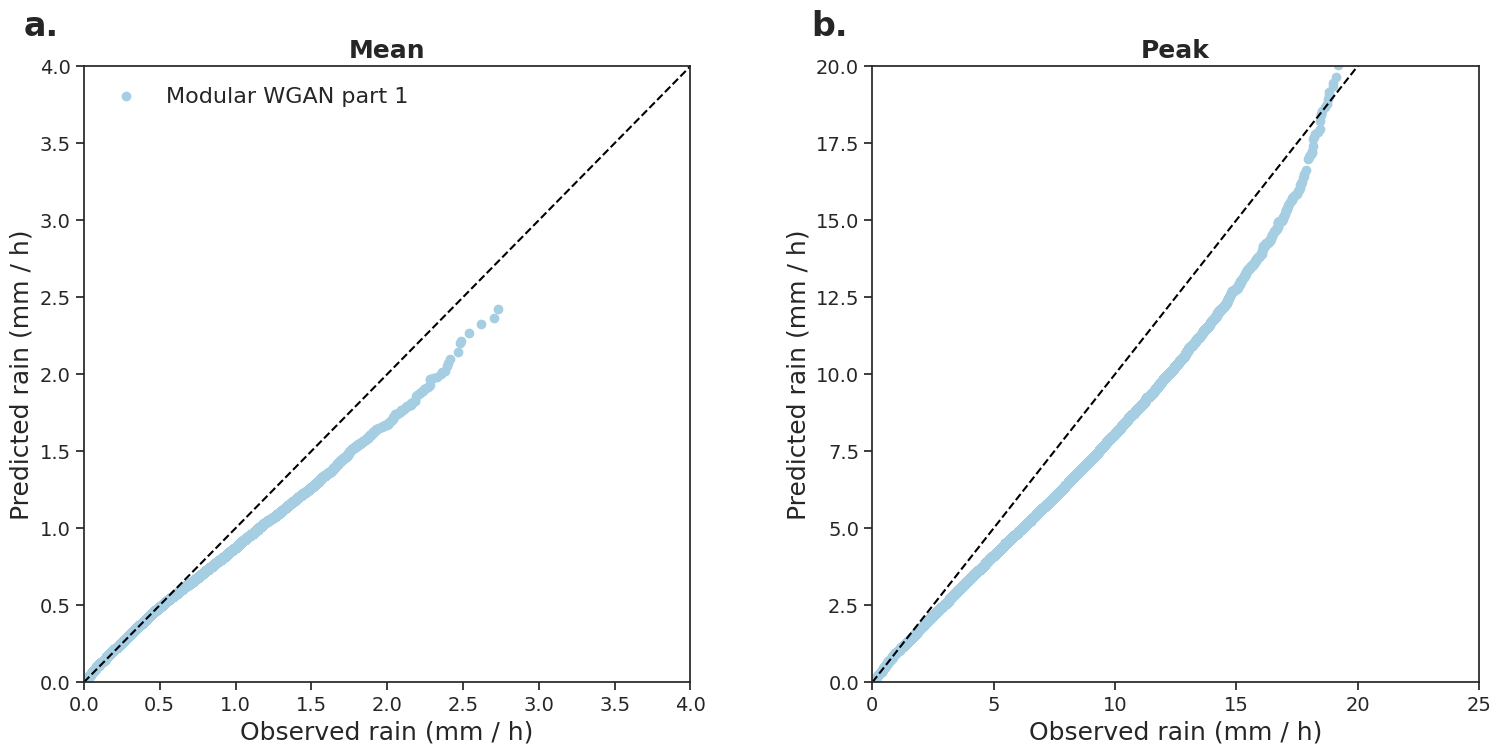

In [13]:
sns.set_style("ticks")
sns.set_context("notebook")
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

# input_mean_p = np.load('data/modular_part1_v1_input_mean.npy') * 3
# input_scalar_mean_p = np.load('data/modular_part1_v1_pred_mean.npy') * 3
# input_max_p = np.load('data/modular_part1_v1_input_max.npy') *3
# input_scalar_max_p = np.load('data/modular_part1_v1_pred_max.npy') * 3



axes[0].scatter(input_mean_p/3,input_scalar_mean_p/3)
axes[1].scatter(input_max_p/3,input_scalar_max_p/3)

x_y = np.arange(0,1500,1)
axes[0].plot(x_y,x_y,'--',color='black')
axes[1].plot(x_y,x_y,'--',color='black')

axes[0].legend(['Modular WGAN part 1'],frameon=False,fontsize=16)
# ax.fill_between(real_p, dsrnngan_min, dsrnngan_max,color='#729ea1',alpha=0.2)
# ax.fill_between(real_p, pred2_min, pred2_max,color='Green',alpha=0.2)
# ax.fill_between(real_p, predog_min, predog_max,color='Pink',alpha=0.2)
axes[0].set_xlabel('Observed rain (mm / h)',fontsize=18)
axes[0].set_ylabel('Predicted rain (mm / h)',fontsize=18)
axes[0].set_title('Mean',fontsize=18,fontweight='bold')
axes[0].tick_params(axis='both', which='major', labelsize=14)

axes[1].set_xlabel('Observed rain (mm / h)',fontsize=18)
axes[1].set_ylabel('Predicted rain (mm / h)',fontsize=18)
axes[1].set_title('Peak',fontsize=18,fontweight='bold')
axes[1].tick_params(axis='both', which='major', labelsize=14)

axes[0].set_ylim([0,4])
axes[0].set_xlim([0,4])
axes[1].set_ylim([0,20])
axes[1].set_xlim([0,25])

axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=24, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=24, weight='bold')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)

# plt.show()
plt.savefig('qq_plot_low_res_inputs_v15.png')
np.save('data/modular_part1_v15_input_mean.npy',input_mean_p/3)
np.save('data/modular_part1_v15_pred_mean.npy',input_scalar_mean_p/3)
np.save('data/modular_part1_v15_input_max.npy',input_max_p/3)
np.save('data/modular_part1_v15_pred_max.npy',input_scalar_max_p/3)

# changing the normalisation of the topography to include negative ocean topography fixed the max issue. dumb mistake lol. 

In [14]:
hrmip = np.concatenate((CMCC_hist_NH_rain,CMCC_hist_SH_rain,hadgem_hist_NH_rain,hadgem_hist_SH_rain),axis=0)
cmip6 = np.concatenate((miroc6_hist_rain,
				miroc6_hist_rain_SH,
				mpi_hist_rain,
				mpi_hist_rain_SH,
				noresm_hist_rain,
				noresm_hist_rain_SH,
				ipsl_hist_rain,
				ipsl_hist_rain_SH,
				mri_hist_rain,
				ipsl_hist_rain_SH,
				mri_hist_rain,
				mri_hist_rain_SH,
				ecearth_hist_rain,
				ecearth_hist_rain_SH,
				cmcclr_hist_rain,
				cmcclr_hist_rain_SH,
				nesm_hist_rain,
				nesm_hist_rain_SH)
				,axis=0)

In [15]:
percentiles = np.arange(0,100,0.01)

In [16]:
real,inputs,pred,meta = load_tc_data(set='test',results='ke_tracks')
print(pred.shape)
scalar_wgan_mean_p,scalar_wgan_mean_min,scalar_wgan_mean_max = calc_ensemble_percentile(pred,'Mean',percentiles)
scalar_wgan_peak_p,scalar_wgan_peak_min,scalar_wgan_peak_max = calc_ensemble_percentile(pred,'Peak',percentiles)
scalar_wgan_core_p,scalar_wgan_core_min,scalar_wgan_core_max = calc_ensemble_percentile(pred,'Core',percentiles)
del pred
del inputs



(15705, 100, 100, 20)
(15705, 100, 100, 20)
(15705, 100, 100, 20)
(15705, 100, 100, 20)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [17]:
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/test_meta.csv')
# real_2,inputs_2,pred_2,meta_2,inputs_og,pred_og,meta_og = load_tc_data(set='test',results='kh_tracks')
real_og,_,_,_,_,_,pred_og,meta_og = load_tc_data(set='test',results='test')
wgan_mean_p,wgan_mean_min,wgan_mean_max = calc_ensemble_percentile(pred_og,'Mean',percentiles)
wgan_peak_p,wgan_peak_min,wgan_peak_max = calc_ensemble_percentile(pred_og,'Peak',percentiles)
wgan_core_p,wgan_core_min,wgan_core_max = calc_ensemble_percentile(pred_og,'Core',percentiles)
del pred_og
# del inputs_2
del inputs_og
# del pred_2


(16007, 100, 100, 20)
(16007, 100, 100, 20)
(16007, 100, 100, 20)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [18]:
modular_pred_2 = np.load('/user/home/al18709/work/gan_predictions_20/modular_part2_lowres_predictions_test_pred-opt_scalar_test_run_more_inputs_pred-opt_modular_part2_raw.npy')
meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/test_meta.csv')
modular_mean,modular_mean_min,modular_mean_max = calc_ensemble_percentile(modular_pred_2,'Mean',percentiles)
modular_peak,modular_peak_min,modular_peak_max = calc_ensemble_percentile(modular_pred_2,'Peak',percentiles)
modular_core,modular_core_min,modular_core_max = calc_ensemble_percentile(modular_pred_2,'Core',percentiles)
del modular_pred_2


(15705, 100, 100, 20)
(15705, 100, 100, 20)
(15705, 100, 100, 20)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [19]:
patchloss_pred = np.load('/user/home/al18709/work/gan_predictions_20/test_pred-opt_modular_part2_patchloss_raw.npy')
patchloss_mean,patchloss_mean_min,patchloss_mean_max = calc_ensemble_percentile(patchloss_pred,'Mean',percentiles)
patchloss_peak,patchloss_peak_min,patchloss_peak_max = calc_ensemble_percentile(patchloss_pred,'Peak',percentiles)
patchloss_core,patchloss_core_min,patchloss_core_max = calc_ensemble_percentile(patchloss_pred,'Core',percentiles)
del patchloss_pred

(15705, 100, 100, 20)
(15705, 100, 100, 20)
(15705, 100, 100, 20)


In [20]:
model = ''
# set mode
mode = 'test'

pred_mraw = np.load('/user/home/al18709/work/gan_predictions_20/test_pred-opt_modular_part2_raw.npy')
mraw_mean,mraw_mean_min,mraw_mean_max = calc_ensemble_percentile(pred_mraw,'Mean',percentiles)
mraw_peak,mraw_peak_min,mraw_peak_max = calc_ensemble_percentile(pred_mraw,'Peak',percentiles)
mraw_core,mraw_core_min,mraw_core_max = calc_ensemble_percentile(pred_mraw,'Core',percentiles)
del pred_mraw
# pred_weighted = np.load('/user/home/al18709/work/gan_predictions_20/validation_weighted_pred-opt_modular_part2_raw.npy')


(15705, 100, 100, 20)
(15705, 100, 100, 20)
(15705, 100, 100, 20)


In [21]:

analysis = 'Mean'
# # scalar_wgan_mean_p,scalar_wgan_mean_min,scalar_wgan_mean_max = calc_ensemble_percentile(pred,analysis,percentiles)
# # wgan_mean_p,wgan_mean_min,wgan_mean_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
# # modular_mean,modular_mean_min,modular_mean_max = calc_ensemble_percentile(modular_pred_2,analysis,percentiles)

# # mweight_mean,mweight_mean_min,mweight_mean_max = calc_ensemble_percentile(pred_weighted,analysis,percentiles)
real_mean_p = np.percentile(np.mean(np.mean(real,axis=1),axis=1), percentiles)
# hrmip_mean_p = np.percentile(np.mean(np.mean(hrmip,axis=1),axis=1), percentiles)
# cmip_mean_p = np.percentile(np.mean(np.mean(cmip6,axis=1),axis=1), percentiles)

In [22]:
analysis = 'Peak'
# # scalar_wgan_peak_p,scalar_wgan_peak_min,scalar_wgan_peak_max = calc_ensemble_percentile(pred,analysis,percentiles)
# # wgan_peak_p,wgan_peak_min,wgan_peak_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
# # modular_peak,modular_peak_min,modular_peak_max = calc_ensemble_percentile(modular_pred_2,analysis,percentiles)
# # mraw_peak,mraw_peak_min,mraw_peak_max = calc_ensemble_percentile(pred_mraw,analysis,percentiles)
# # mweight_peak,mweight_peak_min,mweight_peak_max = calc_ensemble_percentile(pred_weighted,analysis,percentiles)
real_peak_p = np.percentile(np.max(np.max(real,axis=1),axis=1), percentiles)
# hrmip_peak_p = np.percentile(np.max(np.max(hrmip,axis=1),axis=1), percentiles)
# cmip_peak_p = np.percentile(np.max(np.max(cmip6,axis=1),axis=1), percentiles)

In [23]:
# analysis = 'Core'
mask=radMask((25,25),25,real[0,:,:,0])
n,_,_,_ = real.shape
# m,_,_ = hrmip.shape
# o,_,_ = cmip6.shape
mask = np.expand_dims(mask,axis=0)
mask_1 = np.repeat(mask,n,axis=0)
# mask_hrmip = np.repeat(mask,m,axis=0)
# mask_cmip6 = np.repeat(mask,o,axis=0)
# # scalar_wgan_core_p,scalar_wgan_core_min,scalar_wgan_core_max = calc_ensemble_percentile(pred,analysis,percentiles)
# # wgan_core_p,wgan_core_min,wgan_core_max = calc_ensemble_percentile(pred_og,analysis,percentiles)
# # modular_core,modular_core_min,modular_core_max = calc_ensemble_percentile(modular_pred_2,analysis,percentiles)
# # mraw_core,mraw_core_min,mraw_core_max = calc_ensemble_percentile(pred_mraw,analysis,percentiles)
# # mweight_core,mweight_core_min,mweight_core_max = calc_ensemble_percentile(pred_weighted,analysis,percentiles)
real_core_p = np.percentile(np.ma.array(real, mask=mask_1), percentiles)
# hrmip_core_p = np.percentile(np.ma.array(hrmip,mask=mask_hrmip), percentiles)
# cmip_core_p = np.percentile(np.ma.array(cmip6,mask=mask_cmip6), percentiles)

In [24]:
del real
# del pred
# del modular_pred_2
# del pred_og
del imerg_rain
# del pred_mraw
# del pred_weighted

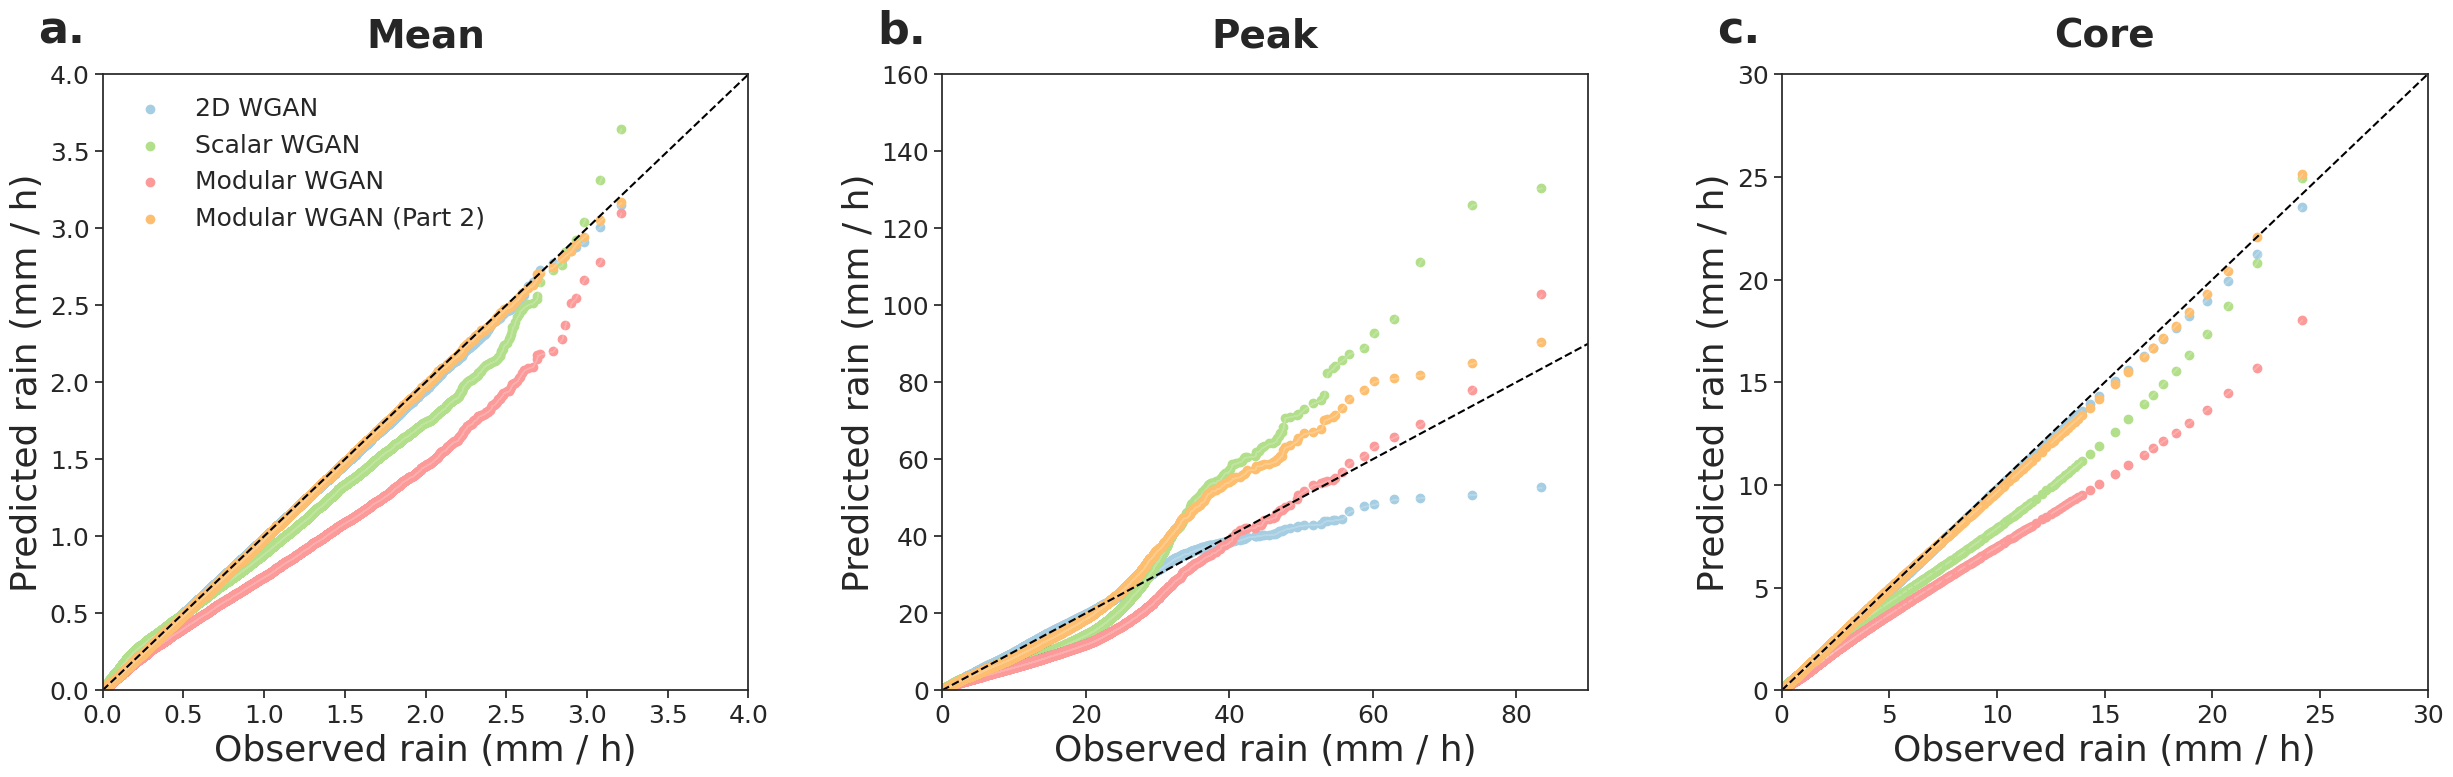

In [25]:

# plt.style.use('ticks')
sns.set_style("ticks")
sns.set_context("notebook")
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False)
# ax1 = plot_qq(axes[0],'Mean',pred,pred_2,pred_og,real)
# ax2 = plot_qq(axes[1],'Peak',pred,pred_2,pred_og,real)
# ax3 = plot_qq(axes[2],'Core',pred,pred_2,pred_og,real)

ax1 = axes[0].scatter(real_mean_p/3,wgan_mean_p/3)
ax12 = axes[0].fill_between(real_mean_p/3, wgan_mean_min/3, wgan_mean_max/3,alpha=0.2)
a1 = axes[0].scatter(real_mean_p/3,scalar_wgan_mean_p/3)
a2 = axes[0].fill_between(real_mean_p/3, scalar_wgan_mean_min/3, scalar_wgan_mean_max/3,alpha=0.2)
b1 = axes[0].scatter(real_mean_p/3,modular_mean/3)
b2 = axes[0].fill_between(real_mean_p/3, modular_mean_min/3, modular_mean_max/3,alpha=0.2)
c1 = axes[0].scatter(real_mean_p/3,mraw_mean/3)
c2 = axes[0].fill_between(real_mean_p/3, mraw_mean_min/3, mraw_mean_max/3,alpha=0.2)

# d1 =axes[0].scatter(real_mean_p/3,patchloss_mean/3)
# d2 =axes[0].fill_between(real_mean_p/3, patchloss_mean_min/3, patchloss_mean_max/3,alpha=0.2)

# axes[0].scatter(real_mean_p/3,mweight_mean/3)
# axes[0].scatter(real_mean_p/3,cmip_mean_p/6)
# axes[0].scatter(real_mean_p/3,hrmip_mean_p/6)

ax2 = axes[1].scatter(real_peak_p/3,wgan_peak_p/3)
axes[1].fill_between(real_peak_p/3, wgan_peak_min/3, wgan_peak_max/3,alpha=0.2)
axes[1].scatter(real_peak_p/3,scalar_wgan_peak_p/3)
axes[1].fill_between(real_peak_p/3, scalar_wgan_peak_min/3, scalar_wgan_peak_max/3,alpha=0.2)
axes[1].scatter(real_peak_p/3,modular_peak/3)
axes[1].fill_between(real_peak_p/3, modular_peak_min/3, modular_peak_max/3,alpha=0.2)
axes[1].scatter(real_peak_p/3,mraw_peak/3)
axes[1].fill_between(real_peak_p/3, mraw_peak_min/3, mraw_peak_max/3,alpha=0.2)
# axes[1].scatter(real_peak_p/3,patchloss_peak/3)
# axes[1].fill_between(real_peak_p/3, patchloss_peak_min/3, patchloss_peak_max/3,alpha=0.2)

# axes[1].scatter(real_peak_p/3,mweight_peak/3)
# axes[1].scatter(real_peak_p/3,cmip_peak_p/6)
# axes[1].scatter(real_peak_p/3,hrmip_peak_p/6)

ax3 = axes[2].scatter(real_core_p/3,wgan_core_p/3)
axes[2].fill_between(real_core_p/3, wgan_core_min/3, wgan_core_max/3,alpha=0.2)
axes[2].scatter(real_core_p/3,scalar_wgan_core_p/3)
axes[2].fill_between(real_core_p/3, scalar_wgan_core_min/3, scalar_wgan_core_max/3,alpha=0.2)
axes[2].scatter(real_core_p/3,modular_core/3)
axes[2].fill_between(real_core_p/3, modular_core_min/3, modular_core_max/3,alpha=0.2)
axes[2].scatter(real_core_p/3,mraw_core/3)
axes[2].fill_between(real_core_p/3, mraw_core_min/3, mraw_core_max/3,alpha=0.2)
# axes[2].scatter(real_core_p/3,patchloss_core/3)
# axes[2].fill_between(real_core_p/3, patchloss_core_min/3, patchloss_core_max/3,alpha=0.2)
# axes[2].scatter(real_core_p/3,mweight_core/3)
# axes[2].scatter(real_core_p/6,cmip_core_p/6)
# axes[2].scatter(real_core_p/6,hrmip_core_p/6)

x_y = np.arange(0,1500,1)
axes[0].plot(x_y,x_y,'--',color='black')
axes[1].plot(x_y,x_y,'--',color='black')
axes[2].plot(x_y,x_y,'--',color='black')

# axes[0].legend(['2D WGAN','Scalar WGAN','Modular WGAN', 'Modular WGAN (raw)','Modular weighted','CMIP6','HighResMIP'],frameon=False,fontsize=16)
# axes[0].legend(['2D WGAN','Scalar WGAN','Modular WGAN', 'Modular WGAN (raw)','CMIP6','HighResMIP'],frameon=False,fontsize=16)
# axes[0].legend(['2D WGAN','Scalar WGAN','Modular WGAN', 'Modular WGAN (Part 2)', 'Patchloss'],frameon=False,fontsize=16)
# axes[0].legend(['2D WGAN','Scalar WGAN','Modular WGAN', 'Modular WGAN (Part 2)'],frameon=False,fontsize=24)

axes[0].legend([ax1,a1,b1,c1],['2D WGAN','Scalar WGAN','Modular WGAN', 'Modular WGAN (Part 2)'],frameon=False,fontsize=18)

# ax.fill_between(real_p, dsrnngan_min, dsrnngan_max,color='#729ea1',alpha=0.2)
# ax.fill_between(real_p, pred2_min, pred2_max,color='Green',alpha=0.2)
# ax.fill_between(real_p, predog_min, predog_max,color='Pink',alpha=0.2)
axes[0].set_xlabel('Observed rain (mm / h)',fontsize=26)
axes[0].set_ylabel('Predicted rain (mm / h)',fontsize=26)
axes[0].set_title('Mean',fontsize=28,fontweight='bold',pad=20)
axes[0].tick_params(axis='both', which='major', labelsize=18)

axes[1].set_xlabel('Observed rain (mm / h)',fontsize=26)
axes[1].set_ylabel('Predicted rain (mm / h)',fontsize=26)
axes[1].set_title('Peak',fontsize=28,fontweight='bold',pad=20)
axes[1].tick_params(axis='both', which='major', labelsize=18)

axes[2].set_xlabel('Observed rain (mm / h)',fontsize=26)
axes[2].set_ylabel('Predicted rain (mm / h)',fontsize=26)
axes[2].set_title('Core',fontsize=28,fontweight='bold',pad=20)
axes[2].tick_params(axis='both', which='major', labelsize=18)


axes[0].set_ylim([0,4])
axes[0].set_xlim([0,4])
axes[1].set_ylim([0,160])
axes[1].set_xlim([0,90])
axes[2].set_ylim([0,30])
axes[2].set_xlim([0,30])
axes[2].set_xticks([0,5,10,15,20,25,30])


axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=32, weight='bold')
axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=32, weight='bold')
axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=32, weight='bold')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)
plt.savefig('qq_plot_Total_test_new_final_11.png',bbox_inches='tight',dpi=600)

# TODO: checkpoint 25 was the best so far!
plt.show()


In [26]:
# real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')

# miroc_fp = '/user/home/al18709/work/gan_predictions_20/miroc_pred-opt_no_rain_test_run_1.npy'
# miroc_corrected_fp = '/user/home/al18709/work/gan_predictions_20/miroc_corrected_pred-opt_no_rain_test_run_1.npy'

# miroc = np.load(miroc_fp)
# miroc_corrected = np.load(miroc_corrected_fp)

In [27]:
# # plt.style.use('ticks')
# sns.set_style("ticks")
# sns.set_context("notebook")
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
# ax1 = plot_qq(axes[0],'Mean',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])
# ax2 = plot_qq(axes[1],'Peak',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])
# # ax3 = plot_qq(axes[0,2],'Total',inputs_hr,real)
# ax4 = plot_qq(axes[2],'Core',pred[:1000],miroc[:1000],miroc_corrected[:1000],real[:1000])


# axes[0].text(-0.1, 1.05, 'a.', transform=axes[0].transAxes, size=24, weight='bold')
# axes[1].text(-0.1, 1.05, 'b.', transform=axes[1].transAxes, size=24, weight='bold')
# axes[2].text(-0.1, 1.05, 'c.', transform=axes[2].transAxes, size=24, weight='bold')
# # axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=24, weight='bold')
# # axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=24, weight='bold')
# # axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=24, weight='bold')

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.35)
# plt.savefig('qq_plot_Total_test_new_32c.png',bbox_inches='tight',dpi=600)
# plt.show()



In [28]:
test = np.load('/user/home/al18709/work/tc_data_flipped/extreme_test_X.npy')
print(test.shape)

(5584, 40, 40)


In [29]:
test = np.load('/user/home/al18709/work/tc_data_mswep/extreme_test_X.npy')
print(test.shape)

(5217, 10, 10)


In [30]:
# ipython -c "%run <notebook>.ipynb"

In [31]:
z = np.float32(np.load('/user/home/al18709/work/tc_data_flipped_t/valid_y.npy'))
print(z.shape)

(15930, 100, 100)


In [32]:
z = z/np.max(z)

In [33]:
print(z.shape)

(15930, 100, 100)


In [34]:
print(np.sum(z<-1))

642125
